# Obtaining communities
The goal of this part is to extract communities in a structural graph. The graph is based on DTI data, subject-wise.
First, we'll perform community detection, relying on Louvain's algorithm coupled with consensus clustering (co-occurence based).

In [1]:
from scipy.io import loadmat
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

import nilearn
from nilearn.datasets import fetch_atlas_aal
import nilearn.plotting as plotting
import numpy as np

/home/guibertf/nilearn/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


First, we load the data of the subject. In particular, we want the structural, which is an adjacency matrix $A$ representing fiber density between any pair of regions, ie:
$$A_{i,j} = \frac{fc(i,j)}{fl(i,j) * \frac{|i|+|j|}{2}}$$ where $fc(i,j)$ the number of fibers from i to j, $fl(i,j)$ the mean fiber length of fibers going from i to j and $|i|$ the size of region $i$.
(Nb: From visual inspection, it seems as though directionality is not taken into account here, making $A$ symmetric)

Since we perform community assignement based on a notion such as degree (or weights in the present case), it makes sense to keep the weights as is and not take their inverse: the more fibers here, the higher the "degree" of node i with j, which will yield to a higher score between them.

In [2]:
# load the subject data
G = nx.convert_matrix.from_numpy_matrix(loadmat('../Data/sub1_SC.mat')['sub1_SC'])
# draw the graph
# Important: call this one only once, so that node positions are fixed afterwards 
# (The spring representation does not necessarily reach a global extremum and might lead to visually 
# different graph orientations and confusion conclusions)
pos = nx.spring_layout(G, scale=10) 

<IPython.core.display.Javascript object>


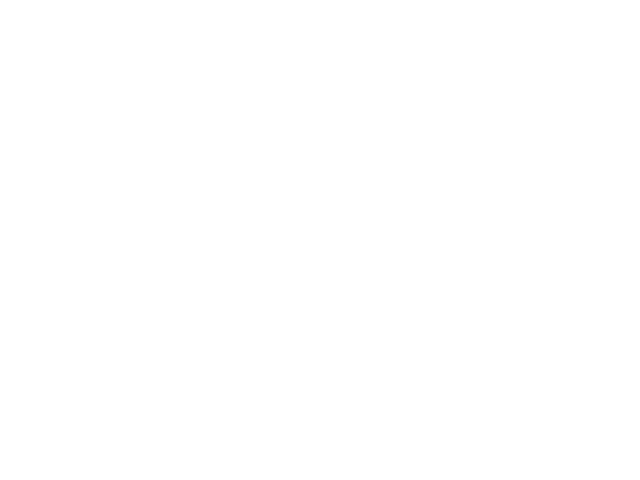

In [3]:
%matplotlib notebook
# compute the best partition
partition = community_louvain.best_partition(G, weight='weight', resolution=0.5)

# color the nodes according to their partition
cmap = cm.get_cmap('hsv', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Let's visualize these nodes on the original atlas. The atlas used is the AAL atlas, without cerebellum and vermis area. In other words, AAL 116, with the first 90 regions used.
Let's take these regions, compute their coordinates, and use it to display our nodes on these coordinates.

In [4]:
aal = fetch_atlas_aal()
# Get coordinates of the regions in AAL atlas and their corresponding labels
coordinates, label_list = plotting.find_parcellation_cut_coords(labels_img=aal['maps'], return_label_names=True) # Note that we compute coordinates for all 116 nodes here, but it doesn't really matter

# Re-order coordinates in sorted order of labels, so that they match with the original atlas' order
coords = coordinates[np.argsort(label_list)]

# We only consider the first 90 regions and ignore cerebellum
limit = 90

def plot_markers_based_on_partition(coords, partition, cmap, output_name='community_example.html'):
    """
    Given markers (defined by their coordinates) as well as a color map function and a partition vector, plot in 
    interactive 3D plot markers in MNI space, overlaid on a glass brain.
    The visualization is saved in the Results subdirectory as an HTML file with the provided name.
    :param coords: 3D coordinates of each marker in MNI space (should be N x 3, where N the number of markers)
    :param partition: Nx1 vector of assignments, denoting for each marker its community
    :param cmap: Colormap function
    :param output_name: Name under which to save visualization. (Default: community_example.html)
    :return: 
    """
    # Plot first 90 region coordinates. Each node is colored according to its community value
    view = plotting.view_markers(coords, cmap(partition)) 
    view.save_as_html('../Results/' + output_name)
    view.open_in_browser()
    return view
    
plot_markers_based_on_partition(coords[:limit], list(partition.values())[:limit], cmap)

## Consensus clustering
Based on this article: https://www.nature.com/articles/srep00336#rightslink

In [5]:
from consensus_clustering import pairwise_accord_naive, are_equal_up_to_bijection

In [6]:
def compute_consensus_from_graph(graph, number_partitions, threshold, resolution):
    """
    Applies Louvain algorithm number_partitions times, with provided resolution.
    For each partition, compute the pairwise accordance (ie: if two nodes are grouped in same community or not), and constitute consensus matrix as the sum of these accordance matrices
    The consensus matrix is then normalized by the total number of partitions and thresholded by the provided threshold value.
    
    :param graph: The graph on which to apply the algorithm
    :param number_partitions: Number of different partitions to compute
    :param threshold: Value with which to threshold the consensus matrix, setting all entries below threshold to zero
    :param resolution: Resolution to use in the Louvain algorithm
    
    :return consensus_matrix, the consensus matrix obtained by the procedure
    :return partitions, the number_partitions partitions obtained by the procedure
    """
    n_nodes = len(list(graph.nodes))
    consensus_matrix = np.zeros((n_nodes, n_nodes))
    partitions = np.zeros((number_partitions, n_nodes))
    # First get consensus matrix
    for i in range(0, number_partitions):
        partition = community_louvain.best_partition(graph, weight='weight', resolution=resolution)
        partitions[i, :] =  np.asarray(list(partition.values()))
        consensus_matrix += pairwise_accord_naive(partitions[i, :])
    consensus_matrix /= number_partitions
    # Threshold
    consensus_matrix[consensus_matrix < threshold] = 0.0
    return consensus_matrix, partitions

In [7]:

def consensus_clustering(graph, number_partitions, threshold, n_steps, resolution):
    """
    Overall consensus clustering algorithm described in https://www.nature.com/articles/srep00336#rightslink
    A first consensus matrix is computed on the original graph.
    Then this consensus matrix is treated as an adjacency matrix itself, on which we apply the consensus procedure until either
    convergence (meaning all partitions are the same) or maximum number of steps are reached.

    :param graph: The original graph on which to perform consensus clustering
    :param number_partitions: Number of partitions at each iteration of the clustering algorithm
    :param threshold: The threshold used in consensus matrix computation
    :param n_steps: The maximum number of steps before termination of the algorithm, should it fail to reach convergence
    :param resolution: The resolution for Louvain's algorithm

    :return partitions: The last number_partitions derived by the algorithm. If algorithm is converged, they are all equal up to bijection.
    :return i: The iteration at which the algorithm finished. Useful to assess how quickly it converged or if it even converged at all.
    """
    consensus_matrix, partitions = compute_consensus_from_graph(graph, number_partitions, threshold, resolution)

    # Until convergence or number of steps exceeded
    for i in range(0, n_steps):
        # Convert consensus matrix to graph
        G = nx.convert_matrix.from_numpy_matrix(consensus_matrix)
        # Get new consensus matrix
        consensus_matrix, partitions = compute_consensus_from_graph(G, number_partitions, threshold, resolution)

        # Now we must ask if all category vectors are the same or not
        should_stop = True
        for vi in range(0, number_partitions - 1):
            should_stop = are_equal_up_to_bijection(partitions[vi], partitions[vi + 1])
            if not should_stop:
                break
        if should_stop:
            break
    return partitions, i

In [8]:
partitions, i = consensus_clustering(G, 100, 0.1, 500, 0.4)

In [9]:
partitions

array([[ 9.,  1.,  2., ...,  8., 11.,  8.],
       [ 8., 10., 11., ...,  6.,  5.,  6.],
       [ 3., 10.,  9., ...,  2.,  4.,  2.],
       ...,
       [10., 11.,  4., ...,  2.,  5.,  2.],
       [10.,  1.,  6., ...,  9.,  8.,  9.],
       [10.,  9.,  4., ...,  8.,  0.,  8.]])

In [10]:
i

0

In this participant's case, we have somehow reached a good partition at the first iteration, which is nice.
Now, we might want to visualize it. Because of convergence, we *know* all partitions are identical because they are related bijectively, so we just pick the first one without loss of generality to display it:

In [11]:
p = partitions[0].astype(int)
cmap = cm.get_cmap('hsv', max(p) + 1)

In [12]:
plot_markers_based_on_partition(coords[:limit], p, cmap)

## Functional graph definition
We have task-based signal, which we can analyze now.

We can define our different connectivity matrices with a sliding window, tapered to account for potential outliers.

In [13]:
FC = loadmat('../Data/sub1_Motor.mat')['sub1_Motor']

In [14]:
def pearsonr(x):
    """
    Simply computes correlation between all pairs of lines in X.
    It is assumed that X is in the form variables x observations.
    If X is in observations x variables it should be transposed before being passed to this function!
    """
    return np.corrcoef(x, rowvar=True)

def sliding_window_corr(x, window_length, window_stride, window_function):
    """
    
    """
    half_window=window_length//2
    window_f = window_function(window_length) # This serves to taper the samples
    start = half_window
    end = x.shape[0] - half_window
    
    n_windows = (end-start)//window_stride + 1 # Check that this is correct
    
    print('There should be {} windows'.format(n_windows))
    print('Start: {} - End: {}'.format(start, end))
    
    correlations = np.zeros((n_windows,x.shape[1], x.shape[1]))
    for i in range(0, n_windows):
        # The window is centered at i*window_stride+start
        center = i*window_stride + start
        # Left side is center - half_window
        # Right side is center + half_window
        # We compute correlation of current sample tampered with window function
        correlations[i]=pearsonr(x[center-half_window:center+half_window].T*window_f)
    return correlations

In [15]:
corrs = sliding_window_corr(FC, 60, 1, lambda x: np.hamming(x))

There should be 509 windows
Start: 30 - End: 538


We will handle the Fisher-Z transformed correlation matrices instead of the raw correlation matrices.

In [16]:
corrs_fzT = [np.arctanh(corr-np.eye(90)) for corr in corrs]

In [17]:
graph_transformed_corrs = [nx.from_numpy_array(corr) for corr in corrs_fzT]

## Segregation and integration measures
Based on the following article https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5148214/ , we reproduce the following measures of integration and segregation.

In [18]:
from graph_measures import compute_system_segregation, compute_participation_coefficient, \
create_communities_from_partition, compute_degree

In [19]:
# Now let us look at our correlation matrices, computed above. 
# For each of them, we will compute e.g system segregation
segregation_ts = [compute_system_segregation(g, p) for g in graph_transformed_corrs]

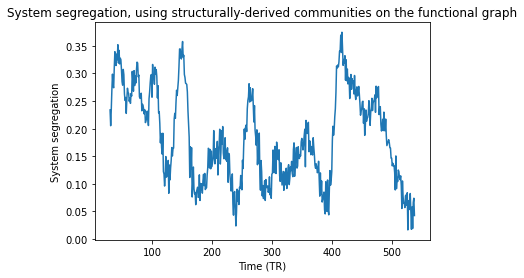

In [20]:
%matplotlib inline
plt.plot(np.arange(30, 539), segregation_ts)
plt.xlabel('Time (TR)')
plt.ylabel('System segregation')
plt.title('System segregation, using structurally-derived communities on the functional graph')
plt.show()

In [21]:
# Now, what of the way system is integrated? Let's look at participation coefficient for this
participation_coeff_ts = [compute_participation_coefficient(g, True, p) for g in graph_transformed_corrs]

In [22]:
participation_coeff_ts = np.asarray(participation_coeff_ts)

In [23]:
participation_coeff_ts.shape

(509, 90)

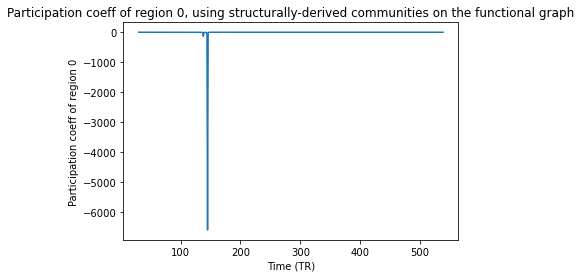

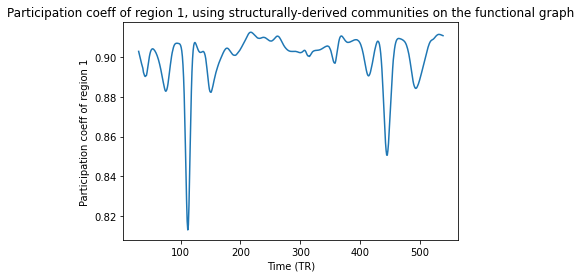

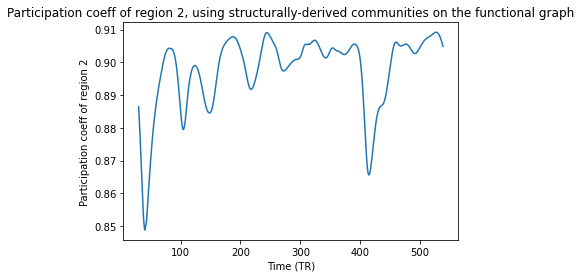

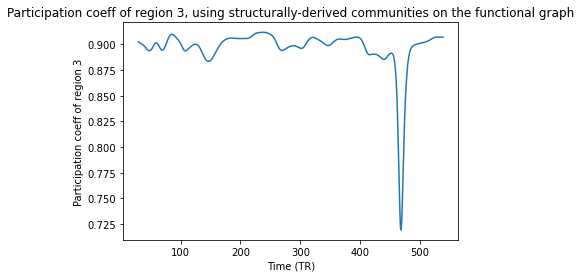

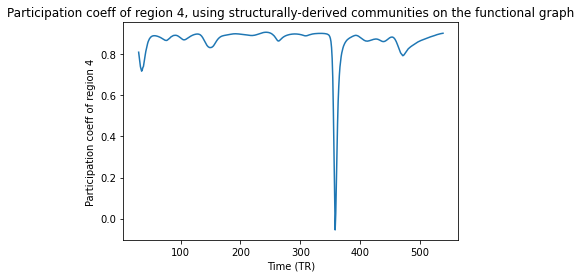

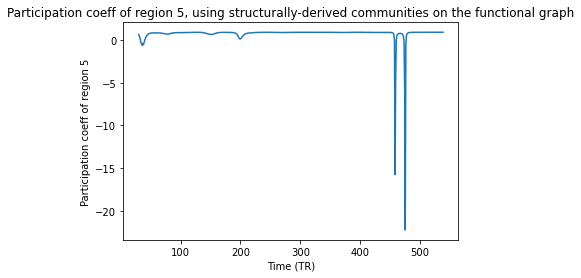

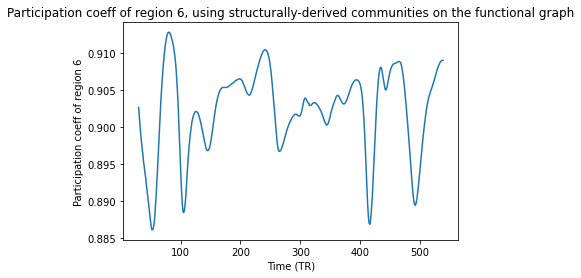

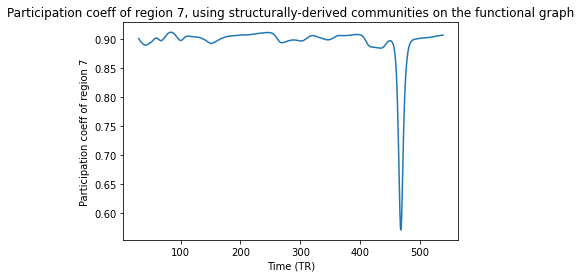

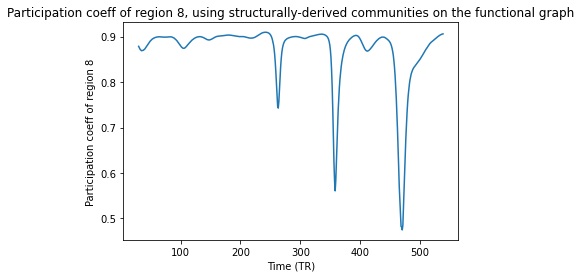

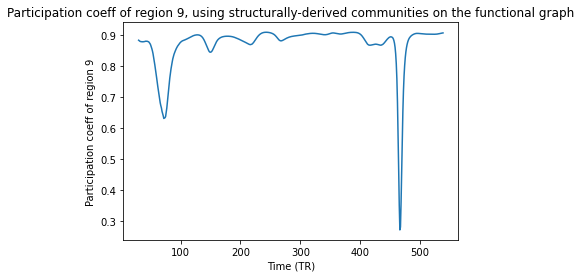

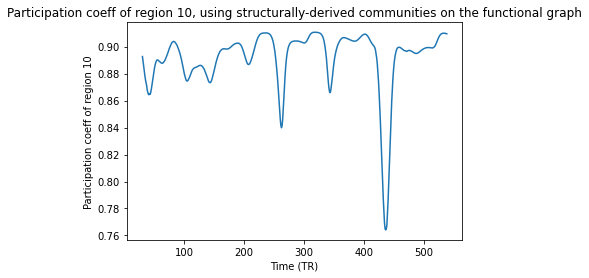

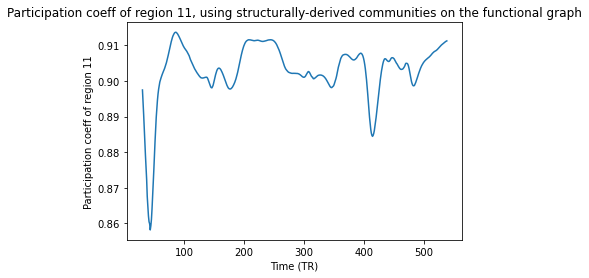

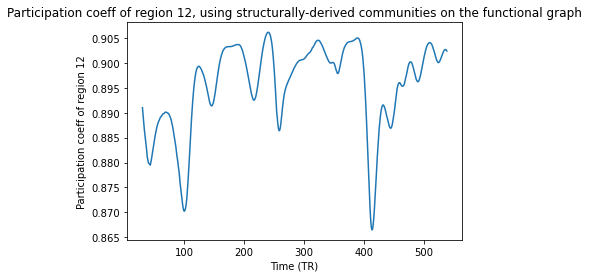

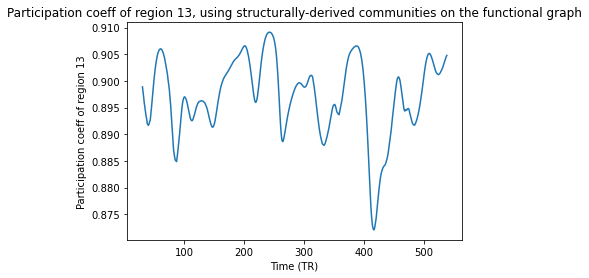

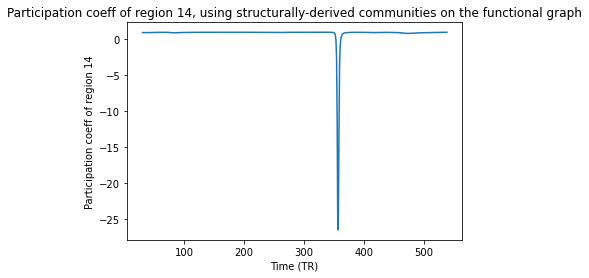

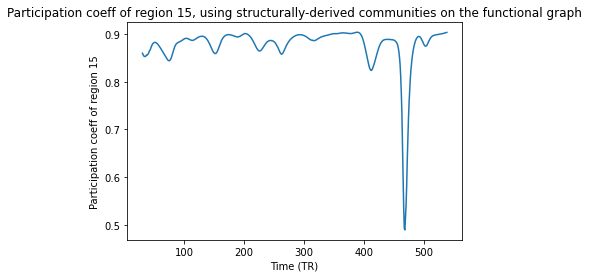

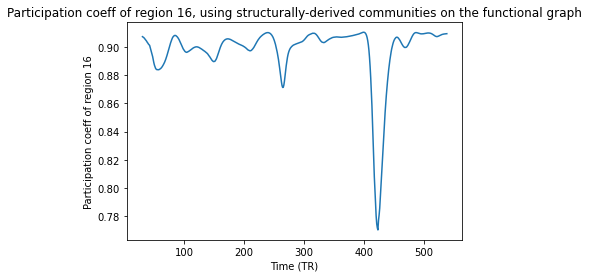

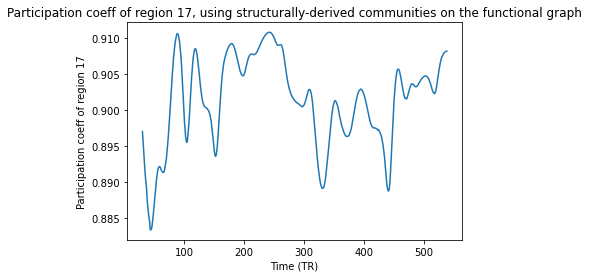

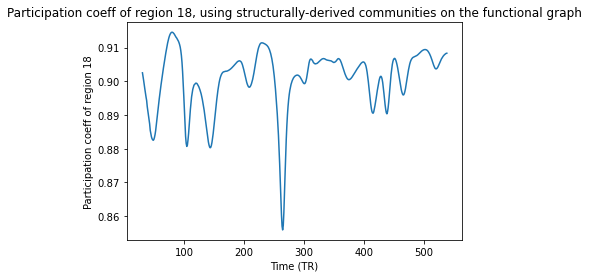

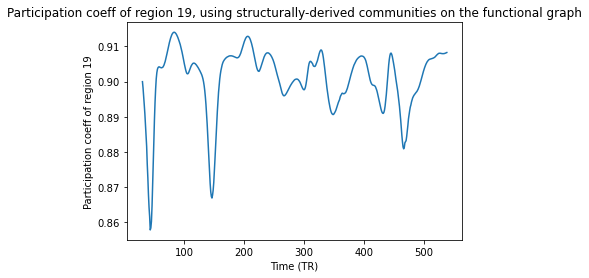

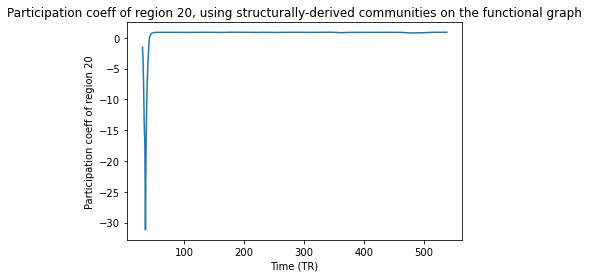

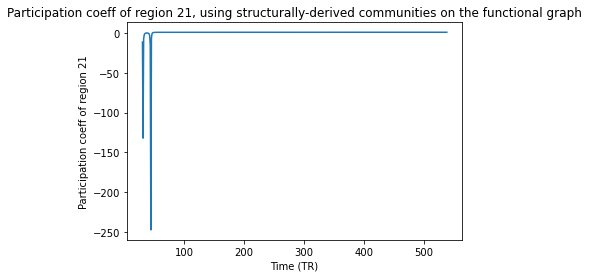

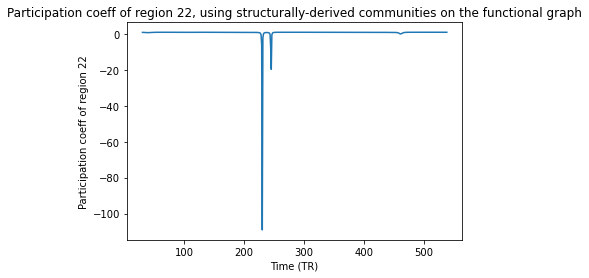

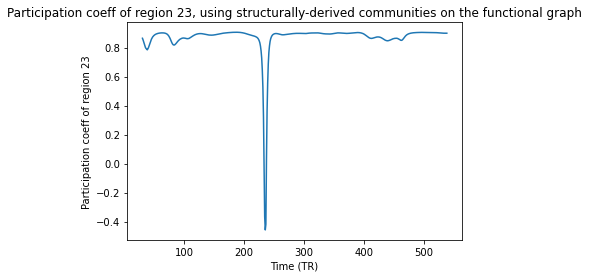

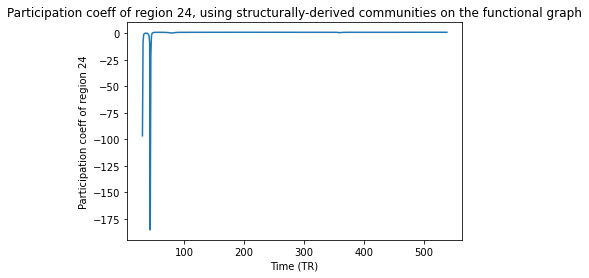

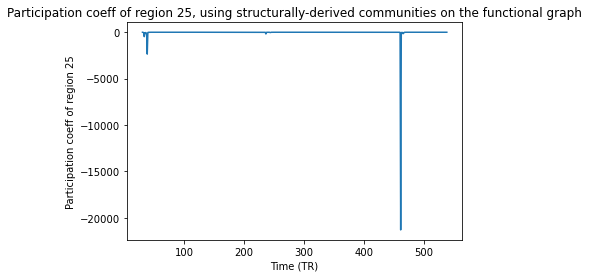

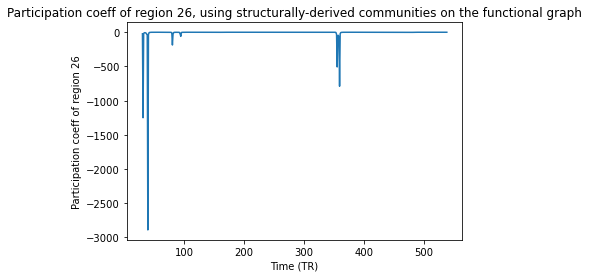

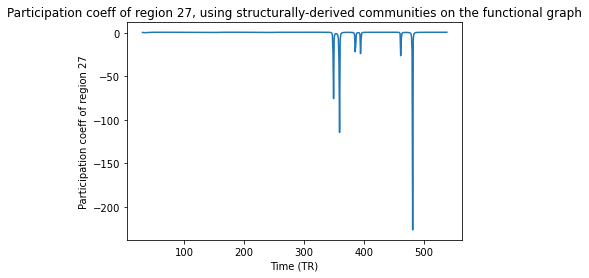

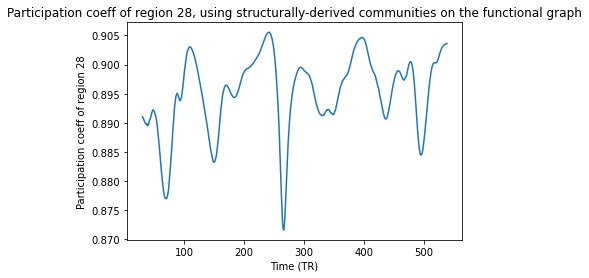

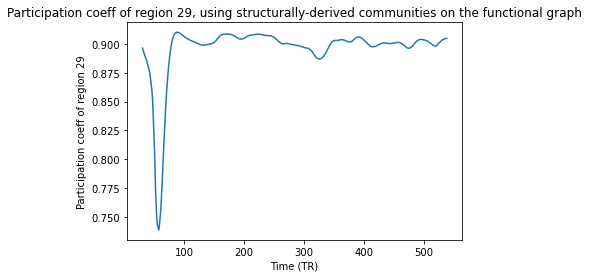

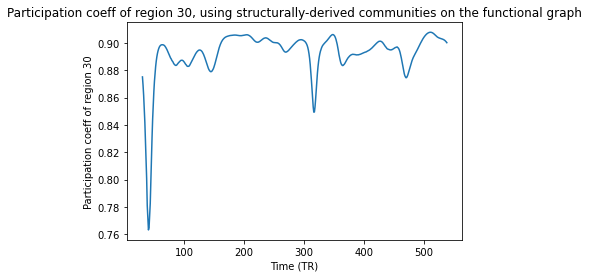

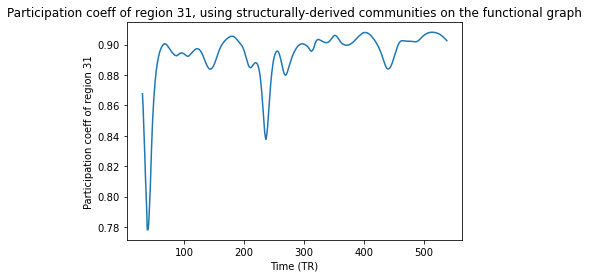

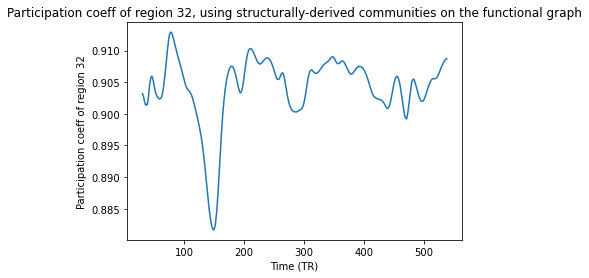

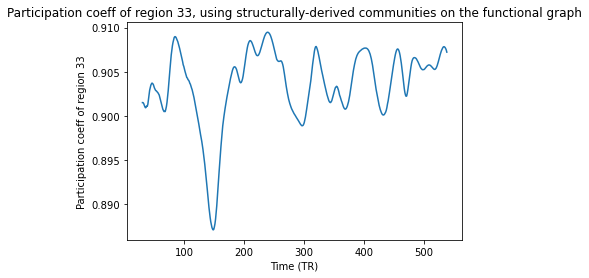

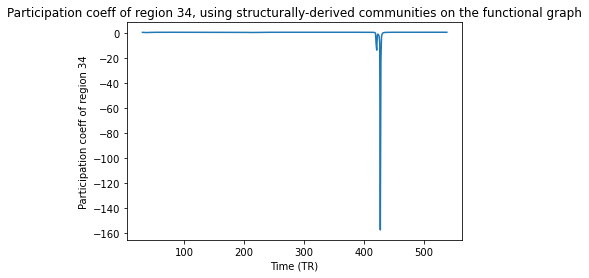

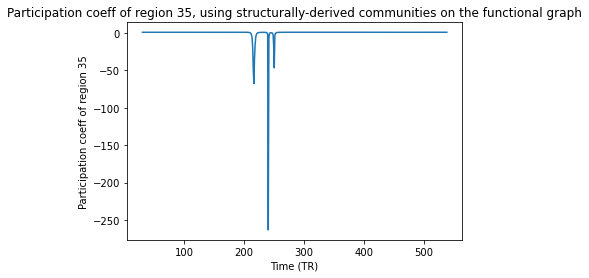

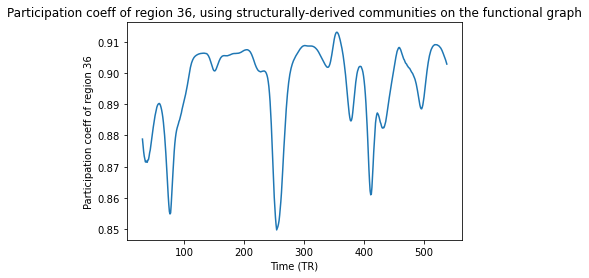

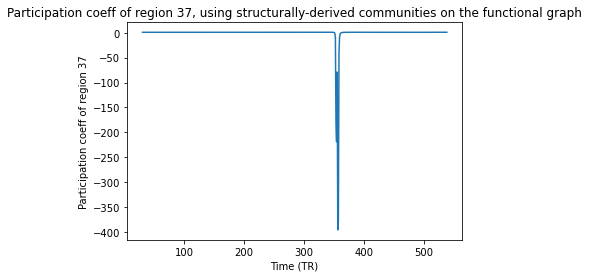

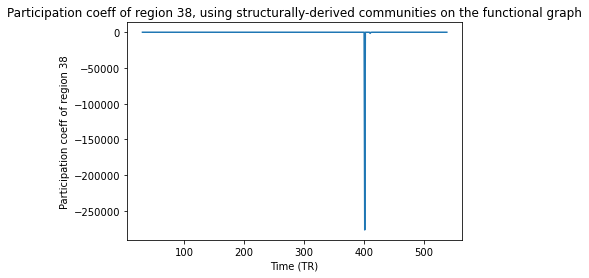

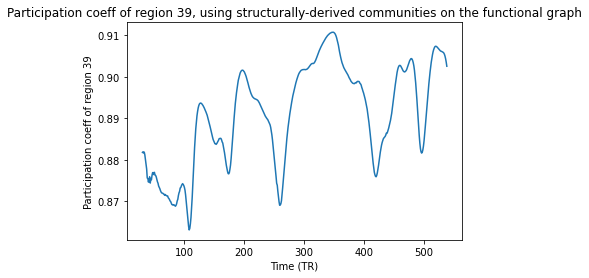

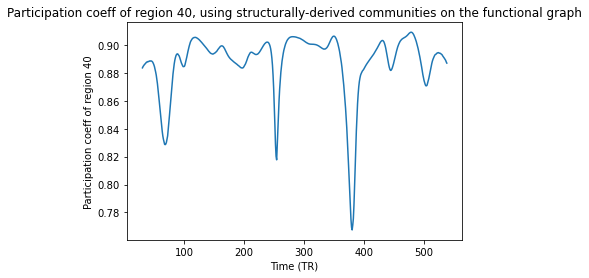

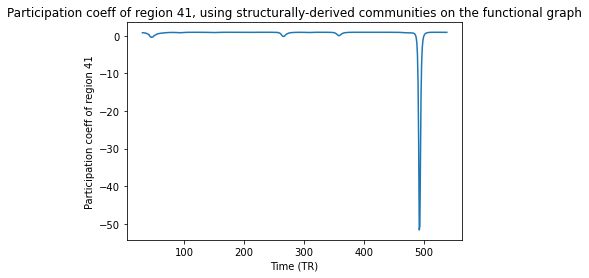

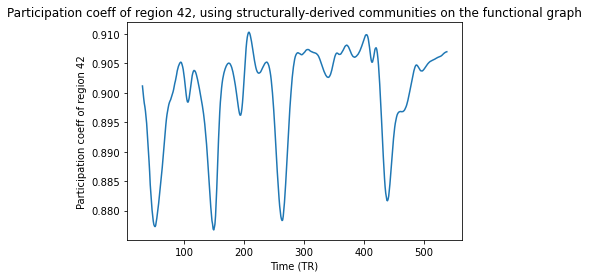

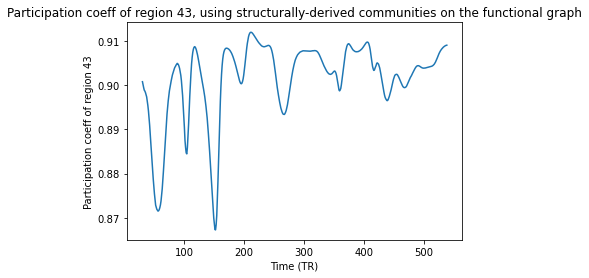

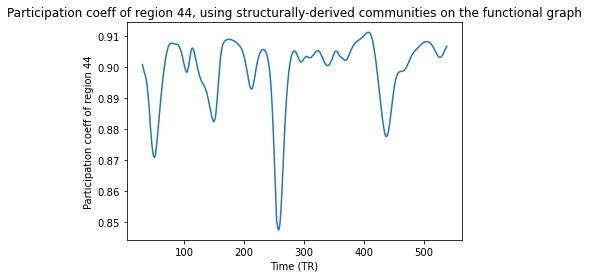

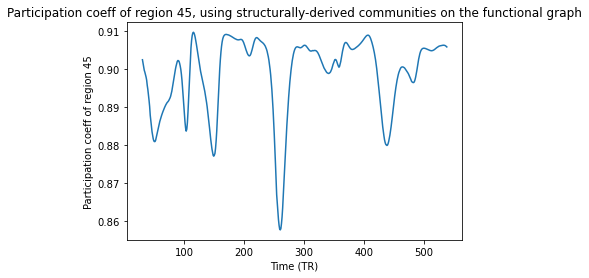

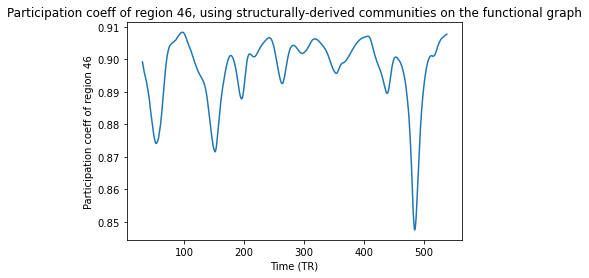

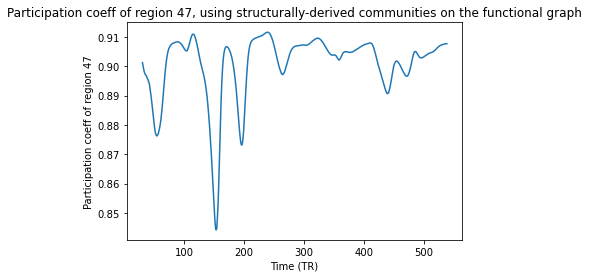

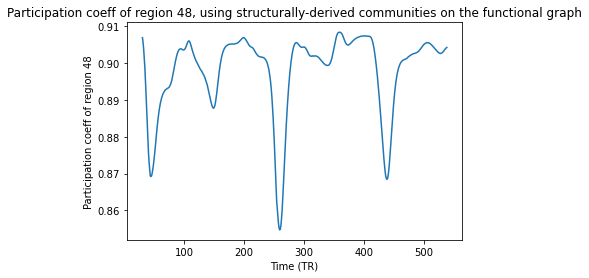

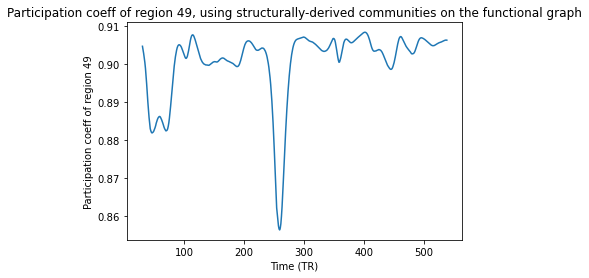

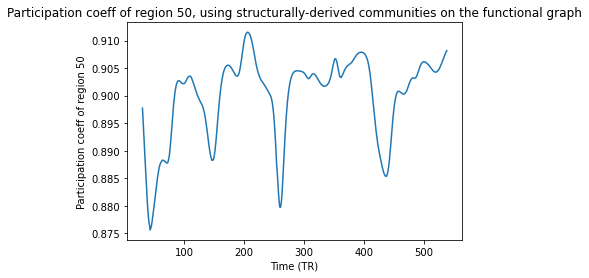

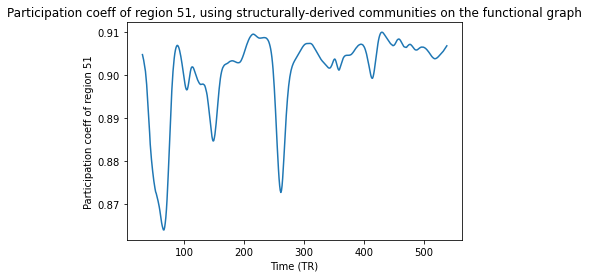

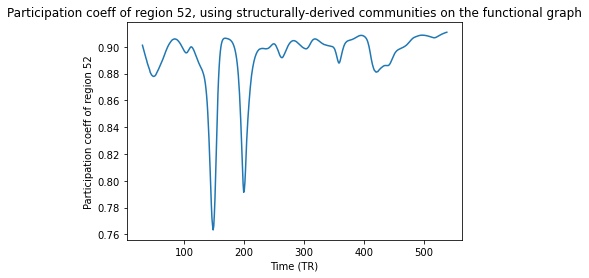

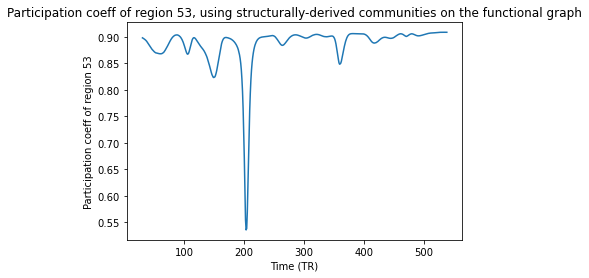

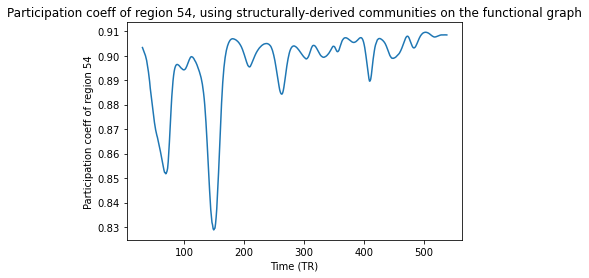

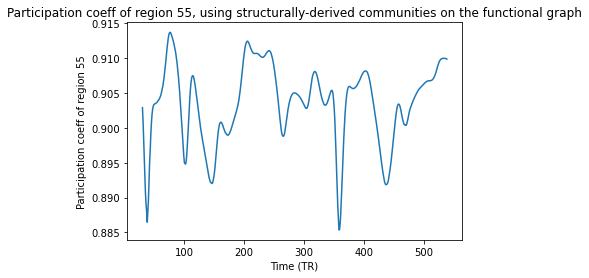

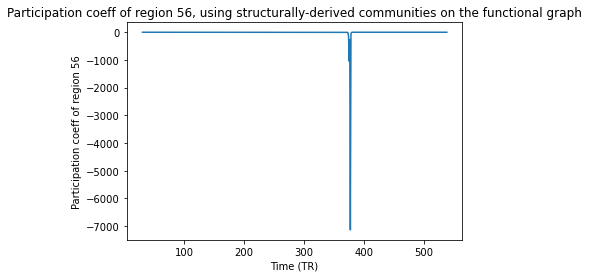

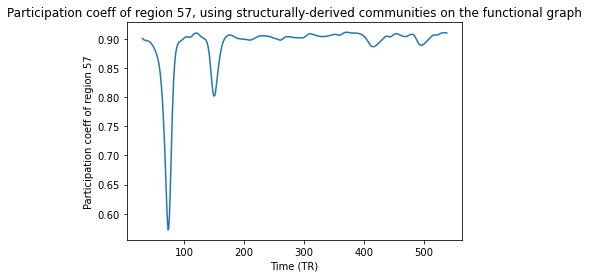

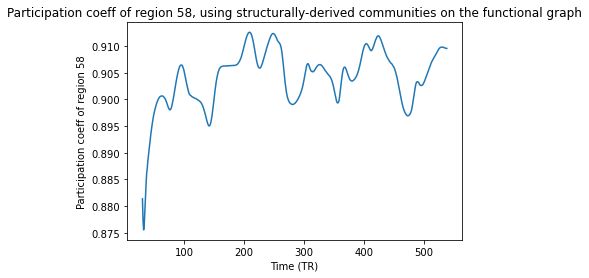

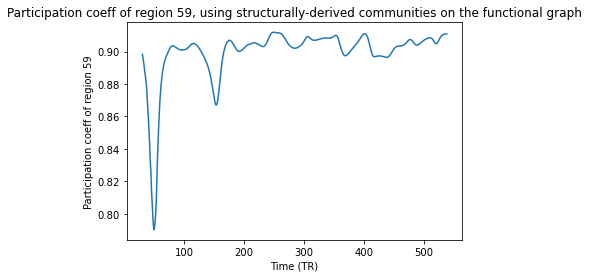

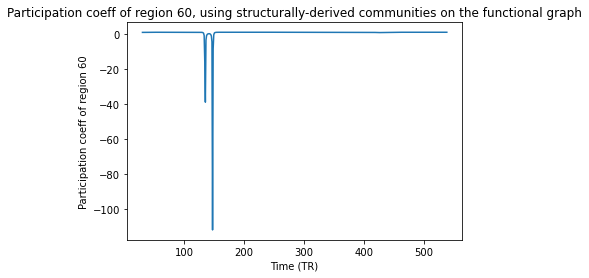

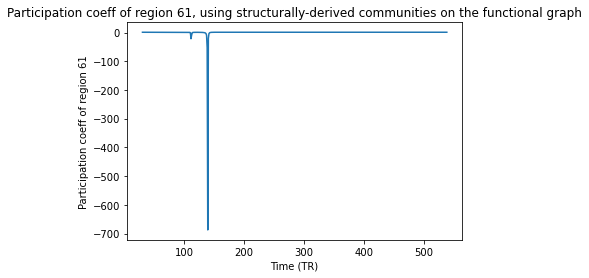

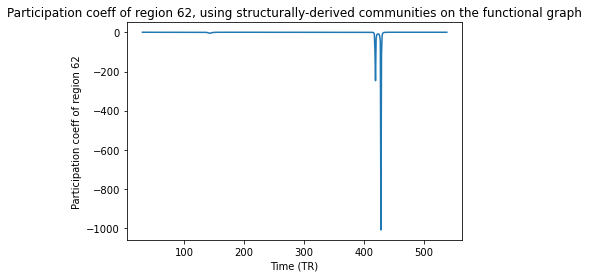

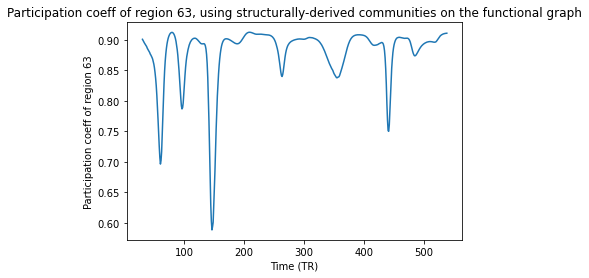

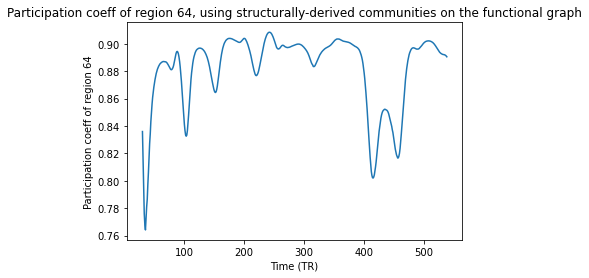

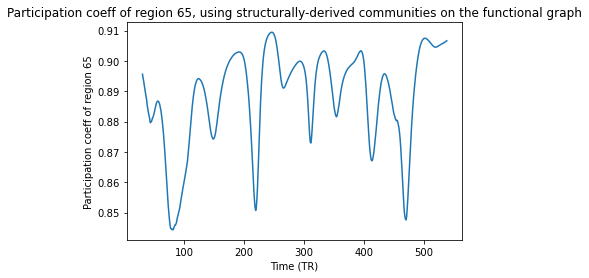

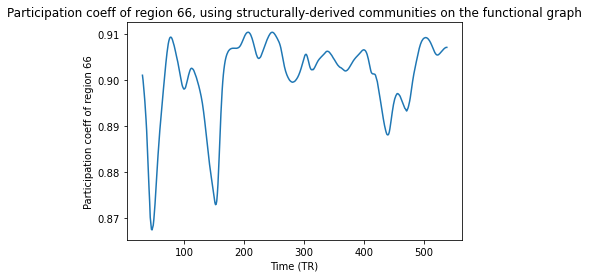

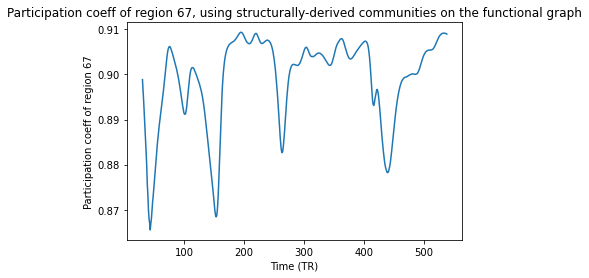

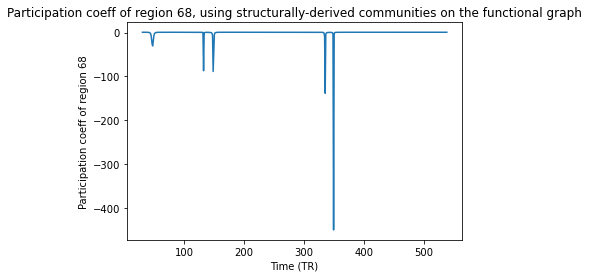

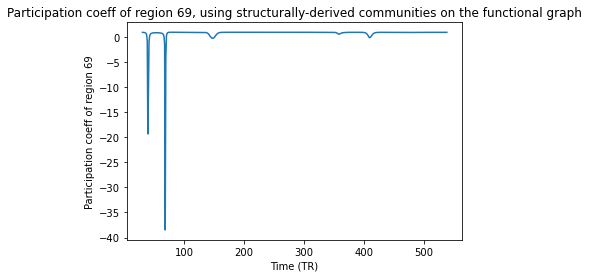

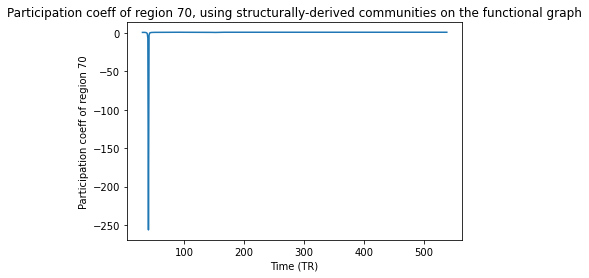

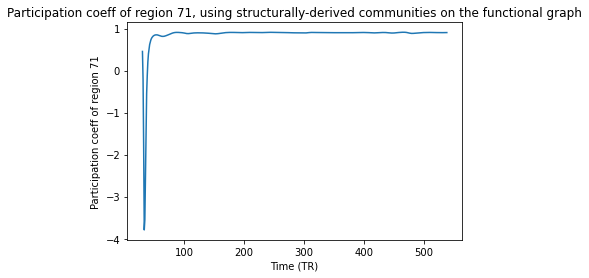

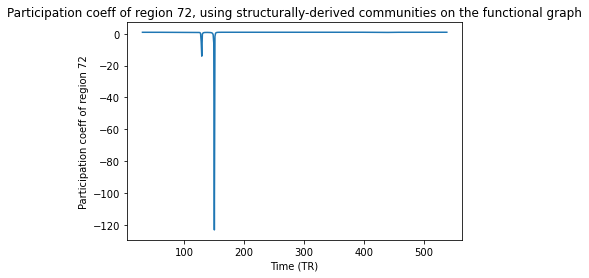

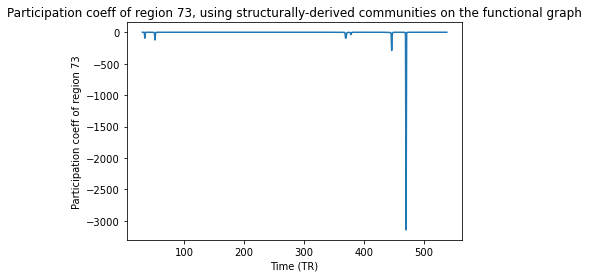

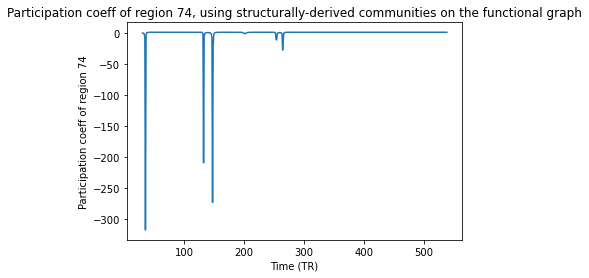

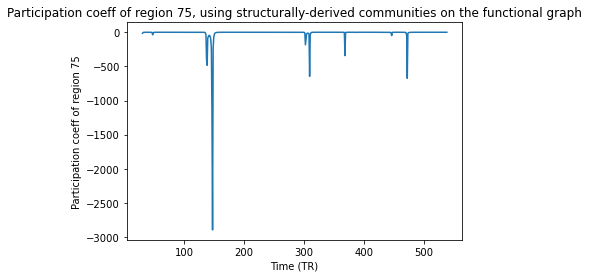

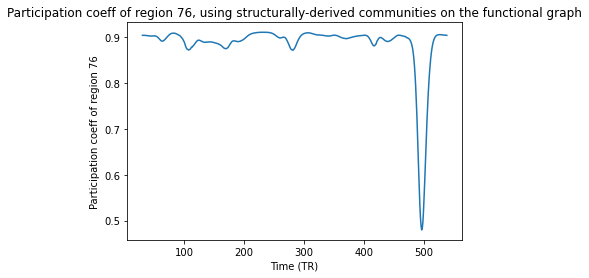

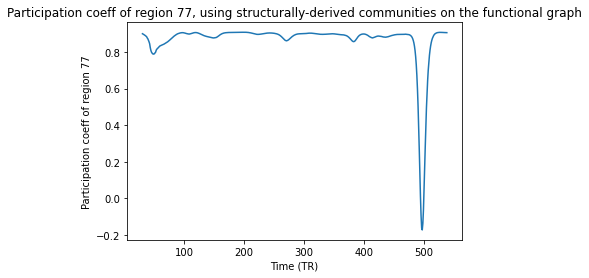

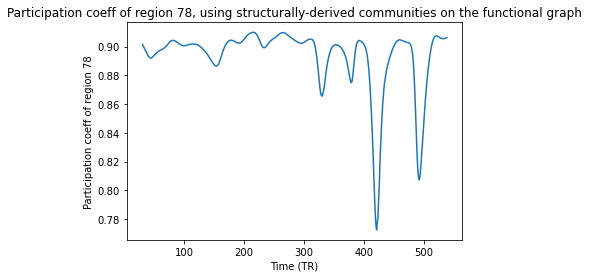

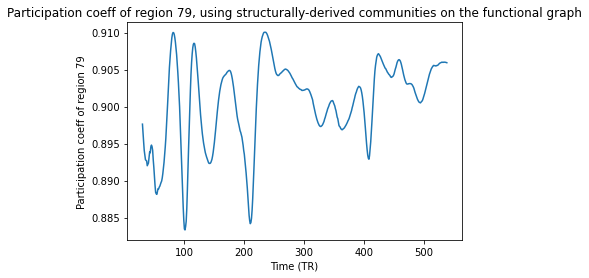

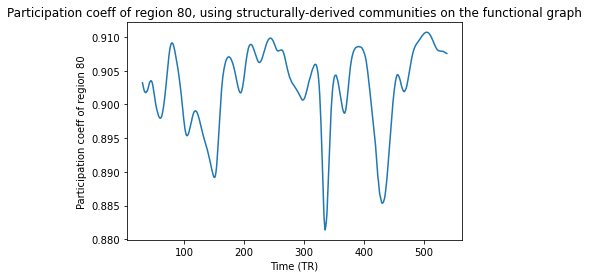

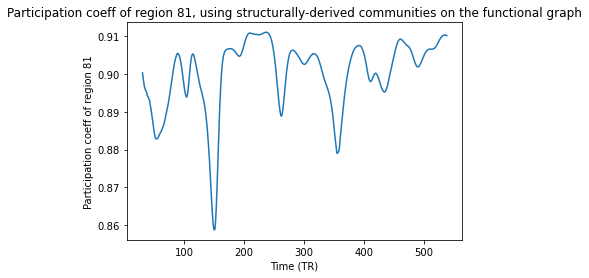

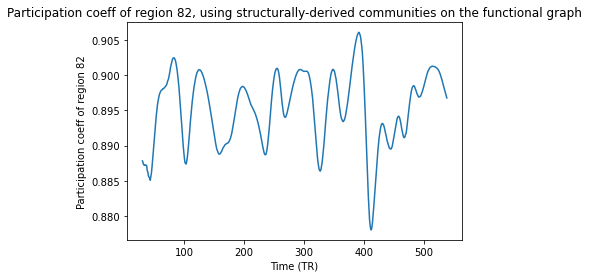

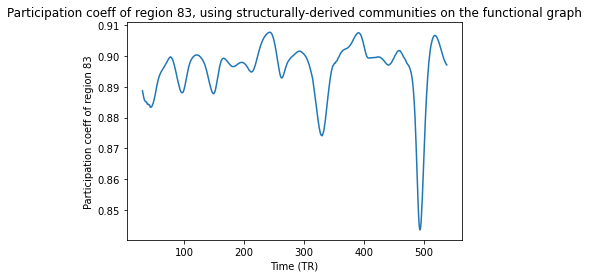

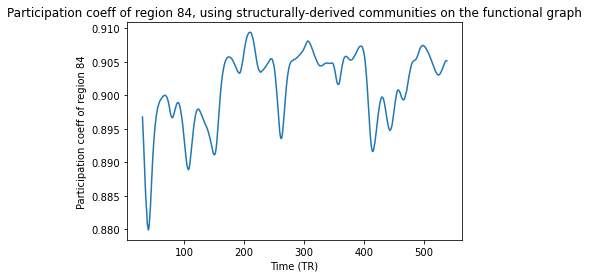

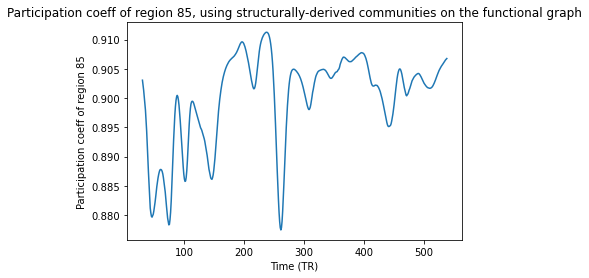

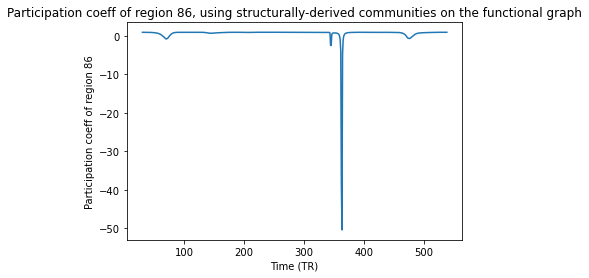

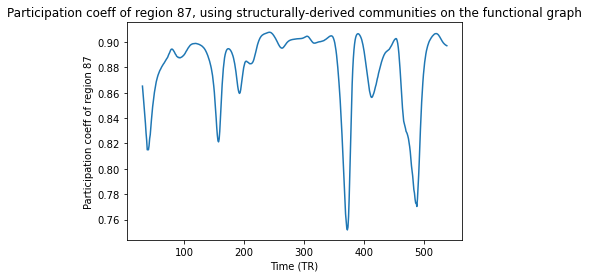

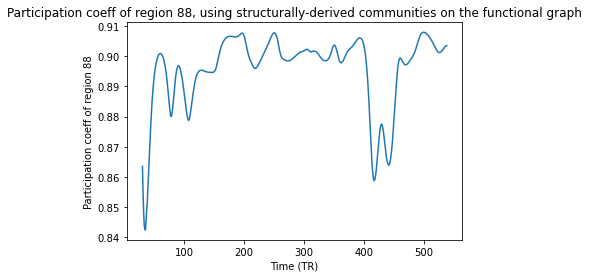

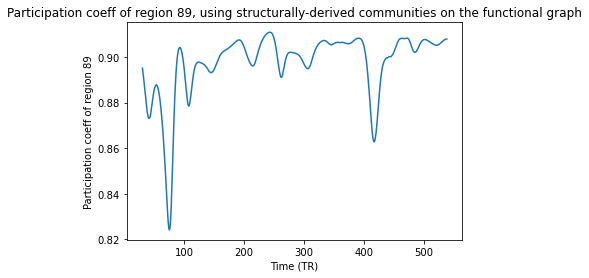

In [24]:
%matplotlib inline
for i in range(0, 90):
    plt.plot(np.arange(30, 539), participation_coeff_ts[:,i])
    plt.xlabel('Time (TR)')
    plt.ylabel('Participation coeff of region {}'.format(i))
    plt.title('Participation coeff of region {}, using structurally-derived communities on the functional graph'.format(i))
    plt.show()

We can immediately see that not all regions behave the same. The range of behaviours is quite different in how one region's relationship to the rest of the graph might fluctuate across time!
What of within-module degree now?

In [28]:
from graph_measures import compute_within_degree
modules_ts = [create_communities_from_partition(g, p) for g in graph_transformed_corrs]

In [32]:
within_degrees_ts = [compute_within_degree(modules_timepoint) for modules_timepoint in modules_ts]

In [35]:
within_degrees_ts = np.asarray(within_degrees_ts)

In [ ]:
%matplotlib inline
for i in range(0, 90):
    plt.plot(np.arange(30, 539), participation_coeff_ts[:,i])
    plt.xlabel('Time (TR)')
    plt.ylabel('Participation coeff of region {}'.format(i))
    plt.title('Participation coeff of region {}, using structurally-derived communities on the functional graph'.format(i))
    plt.show()